In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from funconnect.utility import proximities as prx

# load sample data

In [2]:
# nucleus_id's come from CAVE table nucleus_detection_v0
axon_nuc_ids = [327859, 560530, 222998]
dend_nuc_ids = [587885, 292965, 587744]

In [3]:
axon_id = axon_nuc_ids[0] # select axon
dend_id = dend_nuc_ids[0] # select dendrite

In [4]:
# load data
axon_data = prx.load_sample_skeleton(axon_id, 'axon')
dend_data = prx.load_sample_skeleton(dend_id, 'dend')

# discretize skeleton

In [5]:
# discretization ensures that each skeleton edges is below a threshold length
max_length = 1000 # max length for each edge in nanometers

axon_skeleton = axon_data['vertices'][axon_data['edges']]
axon_skeleton_dsc = prx.discretize_skeleton(
    skeleton=axon_skeleton, 
    max_length=max_length 
).round().astype(int)
axon_verts, axon_edges = prx.convert_skeleton_to_nodes_edges(axon_skeleton_dsc)

dend_skeleton = dend_data['vertices'][dend_data['edges']]
dend_skeleton_dsc = prx.discretize_skeleton(
    skeleton=dend_skeleton, 
    max_length=max_length
).round().astype(int)
dend_verts, dend_edges = prx.convert_skeleton_to_nodes_edges(dend_skeleton_dsc)

# compute proximities

In [6]:
proximity_data = prx.compute_proximities(axon_verts, dend_verts, radius=5000)
if proximity_data:
    axon_verts_prx = proximity_data['verts1_prx']
    dend_verts_prx = proximity_data['verts2_prx']
    axon_edges_prx = prx.filter_edges(axon_edges, np.unique(proximity_data['verts1_inds_prx']))
    dend_edges_prx = prx.filter_edges(dend_edges, np.unique(proximity_data['verts2_inds_prx']))
    axon_len_prx = prx.compute_skeletal_length(axon_verts, axon_edges_prx)
    dend_len_prx = prx.compute_skeletal_length(dend_verts, dend_edges_prx)
    print(f'Proximity found with {axon_len_prx.round()} nanometers of axonal co-travel distance and {dend_len_prx.round()} nanometers of dendritic co-travel distance')
else:
    print(f'No proximities found between the axon of {axon_id} and the dendrite of {dend_id}')

Proximity found with 35457.0 nanometers of axonal co-travel distance and 37557.0 nanometers of dendritic co-travel distance


# plot skeletons

In [7]:
### PLOTTING OPTIONS
xdim, ydim = (0, 1) # choose dimensions to project 3d coords onto (0: mediolateral, 1: cortical depth, 2: anteroposterior)
plot_axon_prx = False # choose whether to plot the axon side or dendrite side of proximity 
zoom_on_prx = True # toggle this to zoom on the proximity or show the entire volume (zooming in only works if there is actually a proximity)
skeleton_kws = dict(
    xdim=xdim,
    ydim=ydim,
    lw=0.25,
    edge_skip=1 # increase to plot less edges (increases plotting speed)
)
skeleton_prx_kws = dict(
    xdim=xdim,
    ydim=ydim,
    lw=1.5,
    color='k'
)

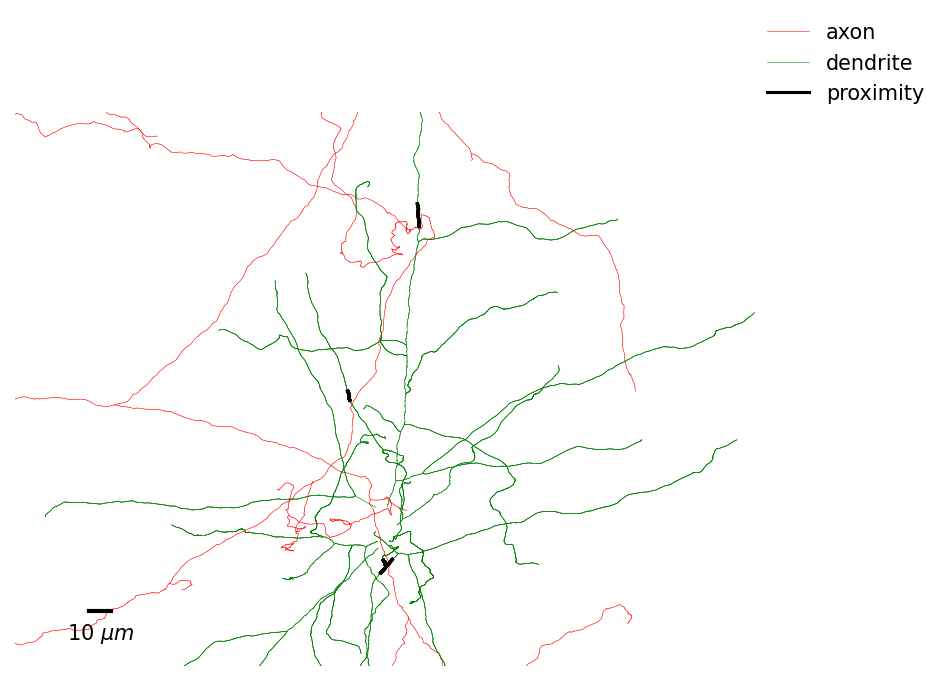

In [8]:
### PLOTTING CODE
# project data to 2D and convert scale to microns
xlim = prx.seg_bounds_nm[:, xdim] / 1000
ylim = prx.seg_bounds_nm[:, ydim] / 1000
axon_verts_2d = axon_verts[:, (xdim, ydim)] / 1000
dend_verts_2d = dend_verts[:, (xdim, ydim)] / 1000
if proximity_data:
    axon_verts_prx_2d = axon_verts_prx[:, (xdim, ydim)] / 1000
    dend_verts_prx_2d = dend_verts_prx[:, (xdim, ydim)] / 1000

fig, ax = plt.subplots(dpi=150)
handles = [prx.add_skeleton(ax, axon_verts_2d, axon_edges, color='r', **skeleton_kws)]
labels = ['axon']
handles += [prx.add_skeleton(ax, dend_verts_2d, dend_edges, color='g', **skeleton_kws)]
labels += ['dendrite']
if proximity_data:
    if plot_axon_prx:
        handles += [prx.add_skeleton(ax, axon_verts_2d, axon_edges_prx, **skeleton_prx_kws)]
    else:
        handles += [prx.add_skeleton(ax, dend_verts_2d, dend_edges_prx, **skeleton_prx_kws)]
    labels += ['proximity']
ax.axis('off')    
ax.legend(handles, labels, loc=(1, 1), frameon=False)
if proximity_data and zoom_on_prx:
    scale_bar_len = 10
    target_aspect_ratio = np.diff(xlim)[0] / np.diff(ylim)[0]
    verts_all_prx = np.vstack([axon_verts_prx_2d, dend_verts_prx_2d])
    verts_bb = np.vstack([verts_all_prx.min(0), verts_all_prx.max(0)])
    verts_bb_exp = prx.expand_bbox_to_aspect_ratio(verts_bb, target_aspect_ratio, scale=1.5)
    ax.set_xlim(*verts_bb_exp[:, 0])
    ax.set_ylim(*verts_bb_exp[:, 1])
else:
    scale_bar_len = 100
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
ax.invert_yaxis()
prx.add_scale_bar(ax, length=scale_bar_len)